# ML Project-Housing price prediction
##Akshay Vaghani

## MultiLinear Regression

In [17]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [18]:
# Importing the dataset
dataset = pd.read_csv('data/train.csv')
dataset_test=pd.read_csv('data/test.csv')


# Missing data analysis and visualization

In [19]:
# find the missing data
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
datatype=dataset.dtypes
missing_data = pd.concat([total, percent,datatype], axis=1, keys=['Total', 'Percent','DataType'])
missing_data_srt=missing_data.sort_values('Total',ascending=False).head(21)
missing_data_srt.head(5)


,Total,Percent,DataType
PoolQC,1453,0.995205,object
MiscFeature,1406,0.963014,object
Alley,1369,0.937671,object
Fence,1179,0.807534,object
FireplaceQu,690,0.472603,object


Text(0.5,1,'number of missing data by predictors')

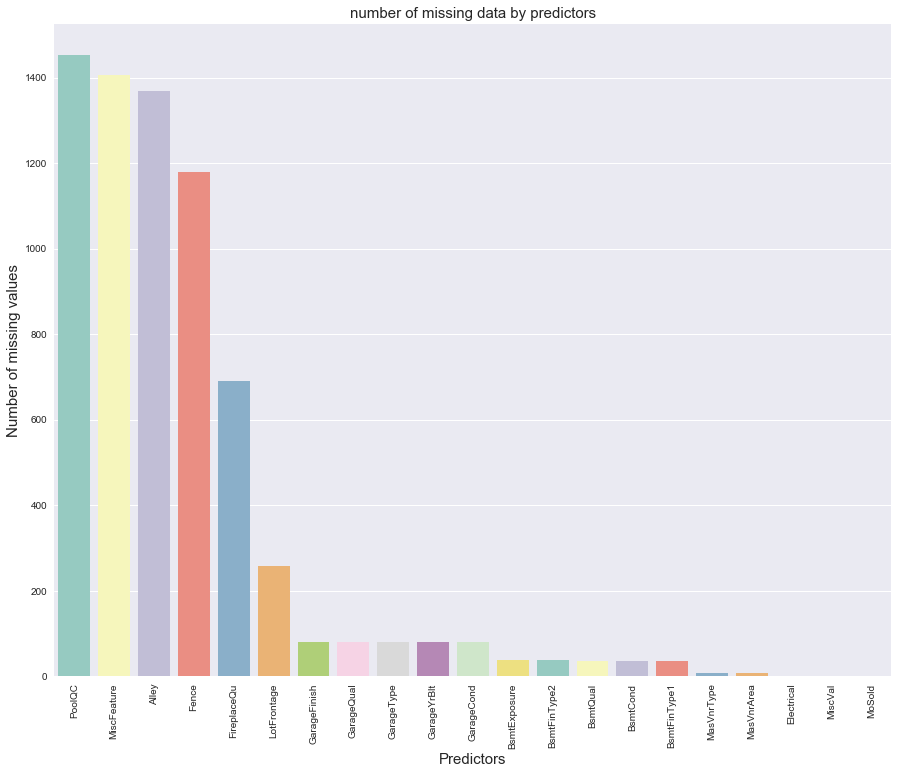

In [20]:
# missing data by features visualization 
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_data_srt.index, y='Total',data=missing_data_srt,color='b',palette='Set3')
plt.xlabel('Predictors', fontsize=15)
plt.ylabel('Number of missing values', fontsize=15)
plt.title('number of missing data by predictors', fontsize=15)

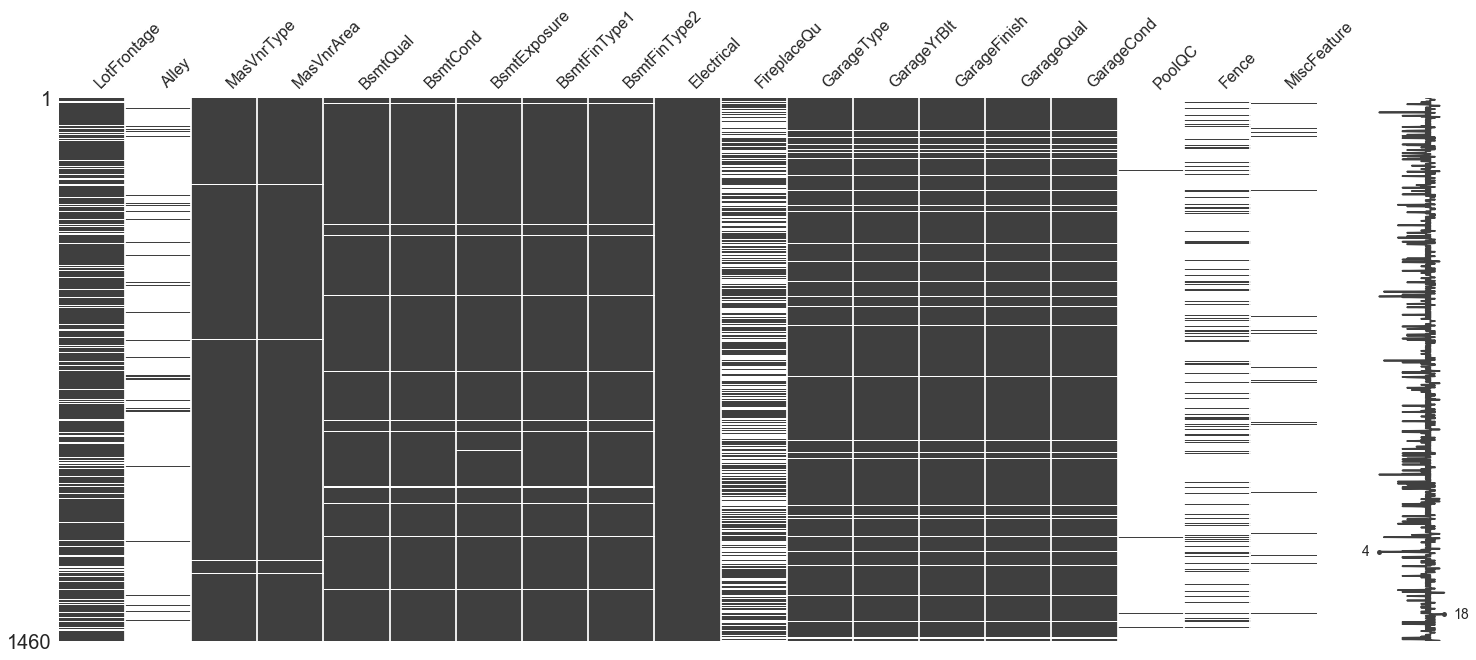

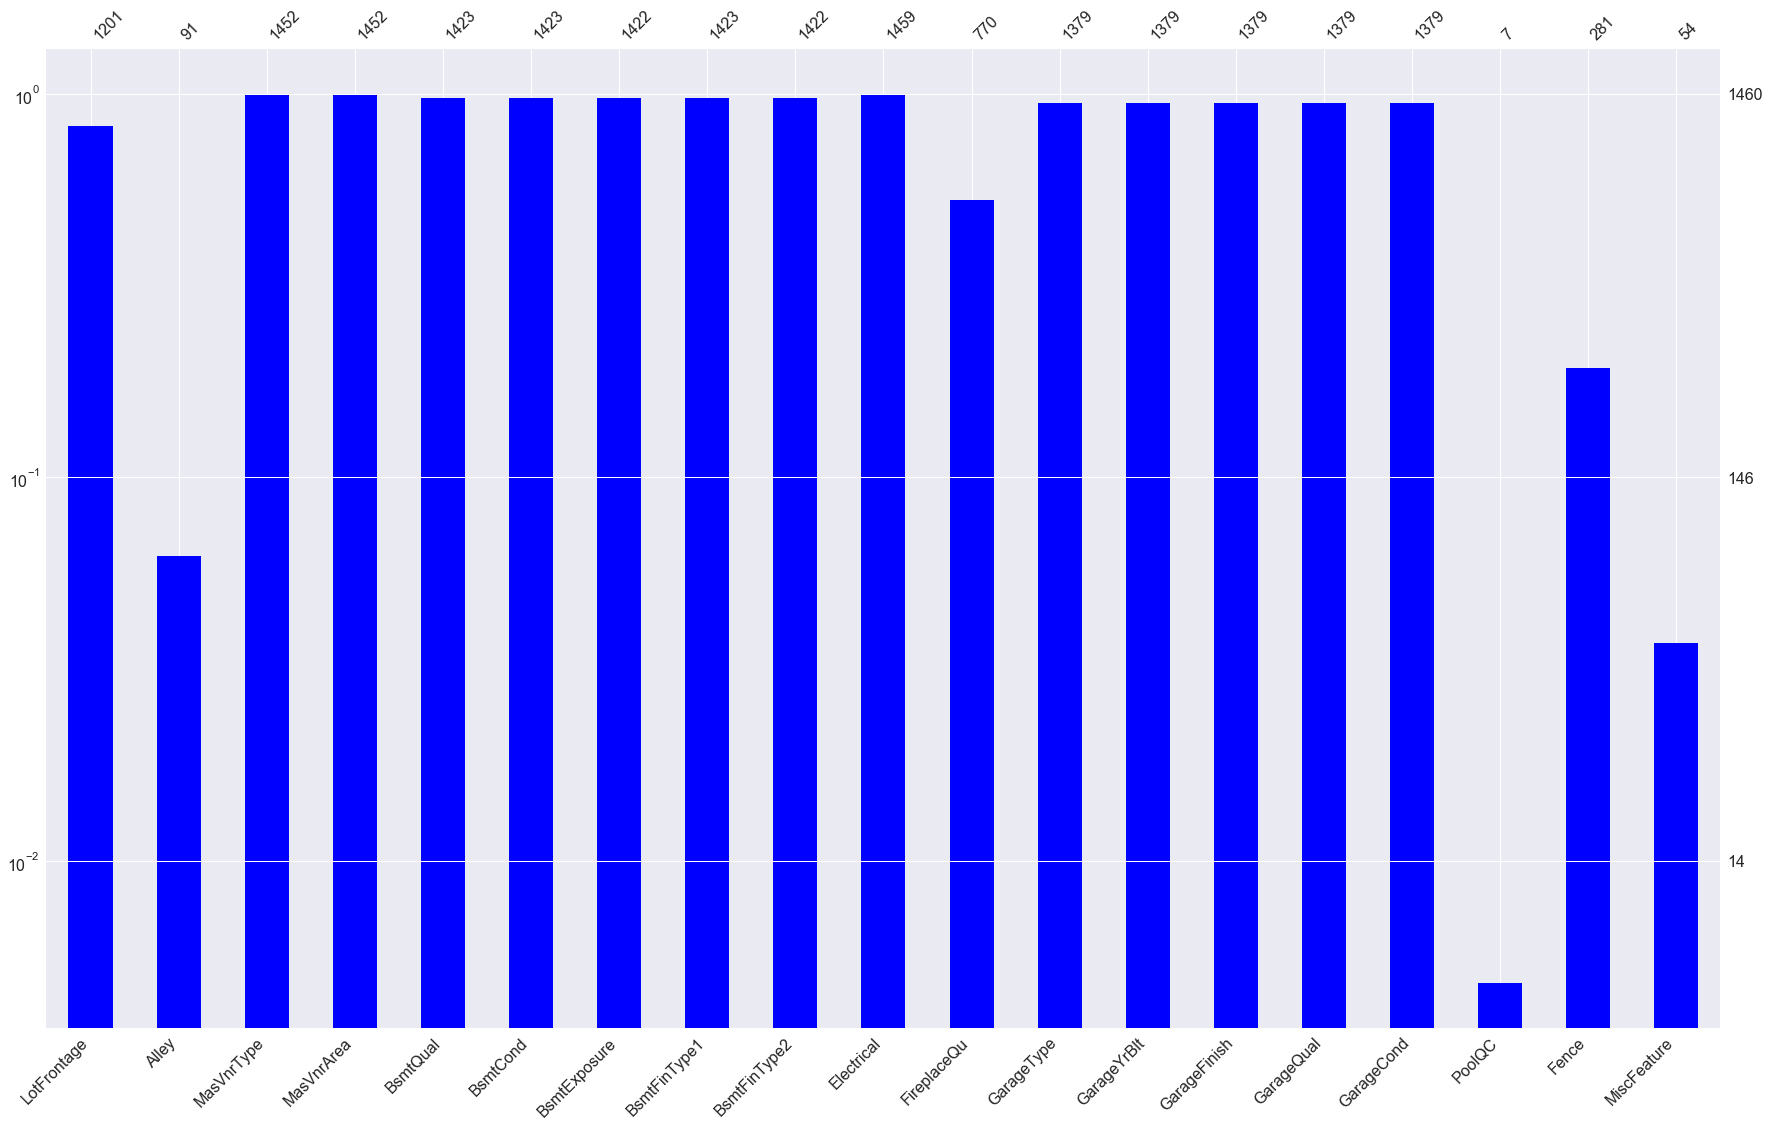

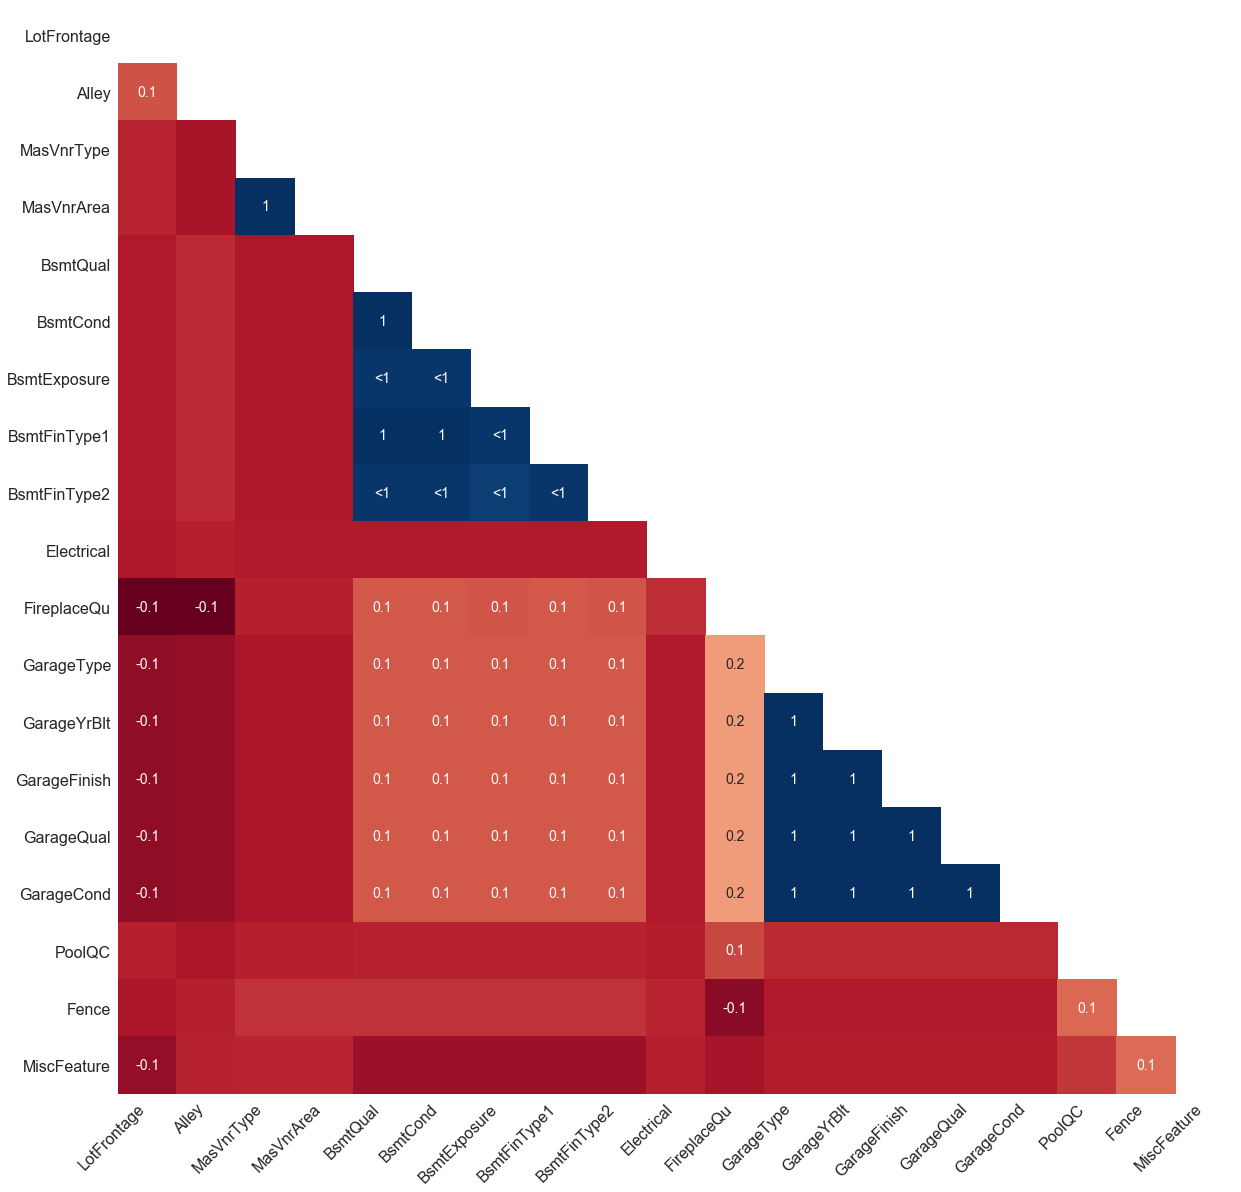

In [21]:
# missing data analysis packages
import missingno as msno
%matplotlib inline

#train_df = pd.read_csv('train_2016_v2.csv', parse_dates=["transactiondate"])
#properties_df = pd.read_csv('properties_2016.csv')
#merged_df = pd.merge(train_df,properties_df)
missing_dataset = dataset.columns[dataset.isnull().any()].tolist()
msno.matrix(dataset[missing_dataset])
msno.bar(dataset[missing_dataset], color="blue", log=True, figsize=(30,18))
msno.heatmap(dataset[missing_dataset], figsize=(20,20))

# Cleaning the data

## function for data cleaning 

In [22]:
# This is better way to clean data for train and test both
# function to fill missing values 

def miss_clean(data):
    
    if 'SalePrice' in data.columns:
        data = data.drop(data[(data['GrLivArea']>4000) & (data['SalePrice']<300000)].index)
    
    #numerical missing columns
    data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median()))
    data['MasVnrArea'].fillna(0, inplace=True)
    data['GarageYrBlt'].fillna(data['YearBuilt'], inplace=True)

    #categorical missing columns where missing is a category
    data['PoolQC'].fillna('None', inplace=True)
    data['MiscFeature'].fillna('None', inplace=True)
    data['Alley'].fillna('None', inplace=True)
    data['Fence'].fillna('None', inplace=True)
    data['FireplaceQu'].fillna('None', inplace=True)
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        data[col] = data[col].fillna('None')
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        data[col] = data[col].fillna('None')
    
    #categorical missing columns by mode of the missings columns
    data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])
    data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
    data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
    data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
    data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])
    data['Functional'] = data['Functional'].fillna(data['Functional'].mode()[0])
    #data["Functional"] = data["Functional"].fillna("Typ")
    data['MasVnrType']=data['MasVnrType'].fillna(data['MasVnrType'].mode()[0])
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        data[col] = data[col].fillna(0)

    # followings was missing after cleaning normally with the code without following on testdata
   # CY suggestion
    data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])
    data['BsmtFullBath'] = data['BsmtFullBath'].fillna(0)
    data['Utilities'] = data['Utilities'].fillna('None')
    data['BsmtHalfBath'] = data['BsmtHalfBath'].fillna(0)
    data['TotalBsmtSF'] = data['TotalBsmtSF'].fillna(0)
    data['BsmtUnfSF'] = data['BsmtUnfSF'].fillna(0)
    data['BsmtFinSF1'] = data['BsmtFinSF1'].fillna(0)
    data['BsmtFinSF2'] = data['BsmtFinSF2'].fillna(0)



    #data['MSZoning'] = data['Electrical'].fillna(data['Electrical'].mode()[0])
    #data['MSZoning'] = data['Electrical'].fillna(data['Electrical'].mode()[0])


        
    #data.drop(['Utilities'], axis=1, inplace=True)
    # data["TotalSF"] = data["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"]
    # data.drop(["TotalBsmtSF","1stFlrSF","2ndFlrSF"], axis=1, inplace=True)
    return data

## function to convert numerical data columns which is actually categorical

In [23]:
# function to convert numerical type to categorical data
# numerical columns are actually categorical and we need to convert it
def num_category(data):
    data['YrSold'] = data['YrSold'].astype('str')
    data['MoSold'] = data['MoSold'].astype('str')
    data['OverallQual'] = data['OverallQual'].astype('str')
    data['MSSubClass'] = data['MSSubClass'].astype('category')
    data['OverallCond'] = data['OverallCond'].astype('str')
    return data

# cleaning actual data

In [24]:
# clean data to run test and train both

# missingness, numerical to categorical and dymmyfy on train data
X1=pd.get_dummies(num_category(miss_clean(dataset)))
# separating features and target
Y1=np.log1p(X1['SalePrice'])
X1.drop(['Id','SalePrice'],axis=1,inplace=True)

# missingness, numerical to categorical and dymmyfy on test data
X2=pd.get_dummies(num_category(miss_clean(dataset_test)))
extra_columns= [col for col in X2.columns if not (col in X1.columns)]
X2.drop(extra_columns,axis=1, inplace=True)
X2=X2.merge(X1, how='left').fillna(0)

## Correlation matrix and Scatter plot

In [25]:
# separate train and test data in to numerical data and categorica data
num_data=dataset.select_dtypes(exclude=['object'])
cat_data=dataset.select_dtypes(exclude=['number'])
num_data_test=dataset_test.select_dtypes(exclude=['object'])
cat_data_test=dataset_test.select_dtypes(exclude=['number'])
num_data.head()
#cat_data.head()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [26]:
# imputing missing values as a average of the columns
# numerical columns only 
# num_data=num_data.fillna(num_data.mean())
# num_data.head(5)

#or

#following is other suggestion from Kaggle kernal
num_data['LotFrontage']=dataset.groupby(['Neighborhood'])["LotFrontage"].transform(lambda x: x.fillna(x.median()))
num_data["MasVnrArea"] = dataset['MasVnrArea'].fillna(0)
num_data["GarageYrBlt"] = dataset['GarageYrBlt'].fillna(0)
# you might need to GarageYrBlt column
#num_data.isnull().sum().sort_values(ascending=False)

In [27]:
# check numerical columns missing data
num_data.isnull().sum().sort_values(ascending=False).head(5)

# check categorical columns mising values
cat_data.isnull().sum().sort_values(ascending=False).head(5)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
dtype: int64

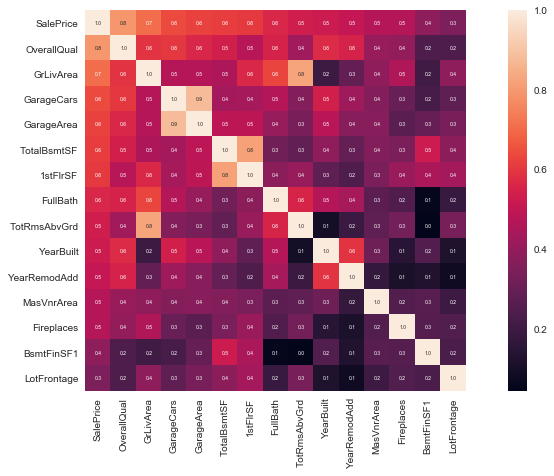

In [28]:
#correlation matrix
#largest columns of the correlation matrix
#most important corelated columns
# missing columns represent the missing values
corrmat = num_data.corr()
k = 15 #number of variables for heatmap
# largest columns of the sales price correlation matrix
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(num_data[cols].values.T) # correlation matric of the data table after taking transpose of the data table
#sns.set(font_scale=1.25)
plt.figure(figsize=(15,7))
hmap = sns.heatmap(cm, cbar=True, annot=True ,square=True, fmt='.1f', annot_kws={'size': 5}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

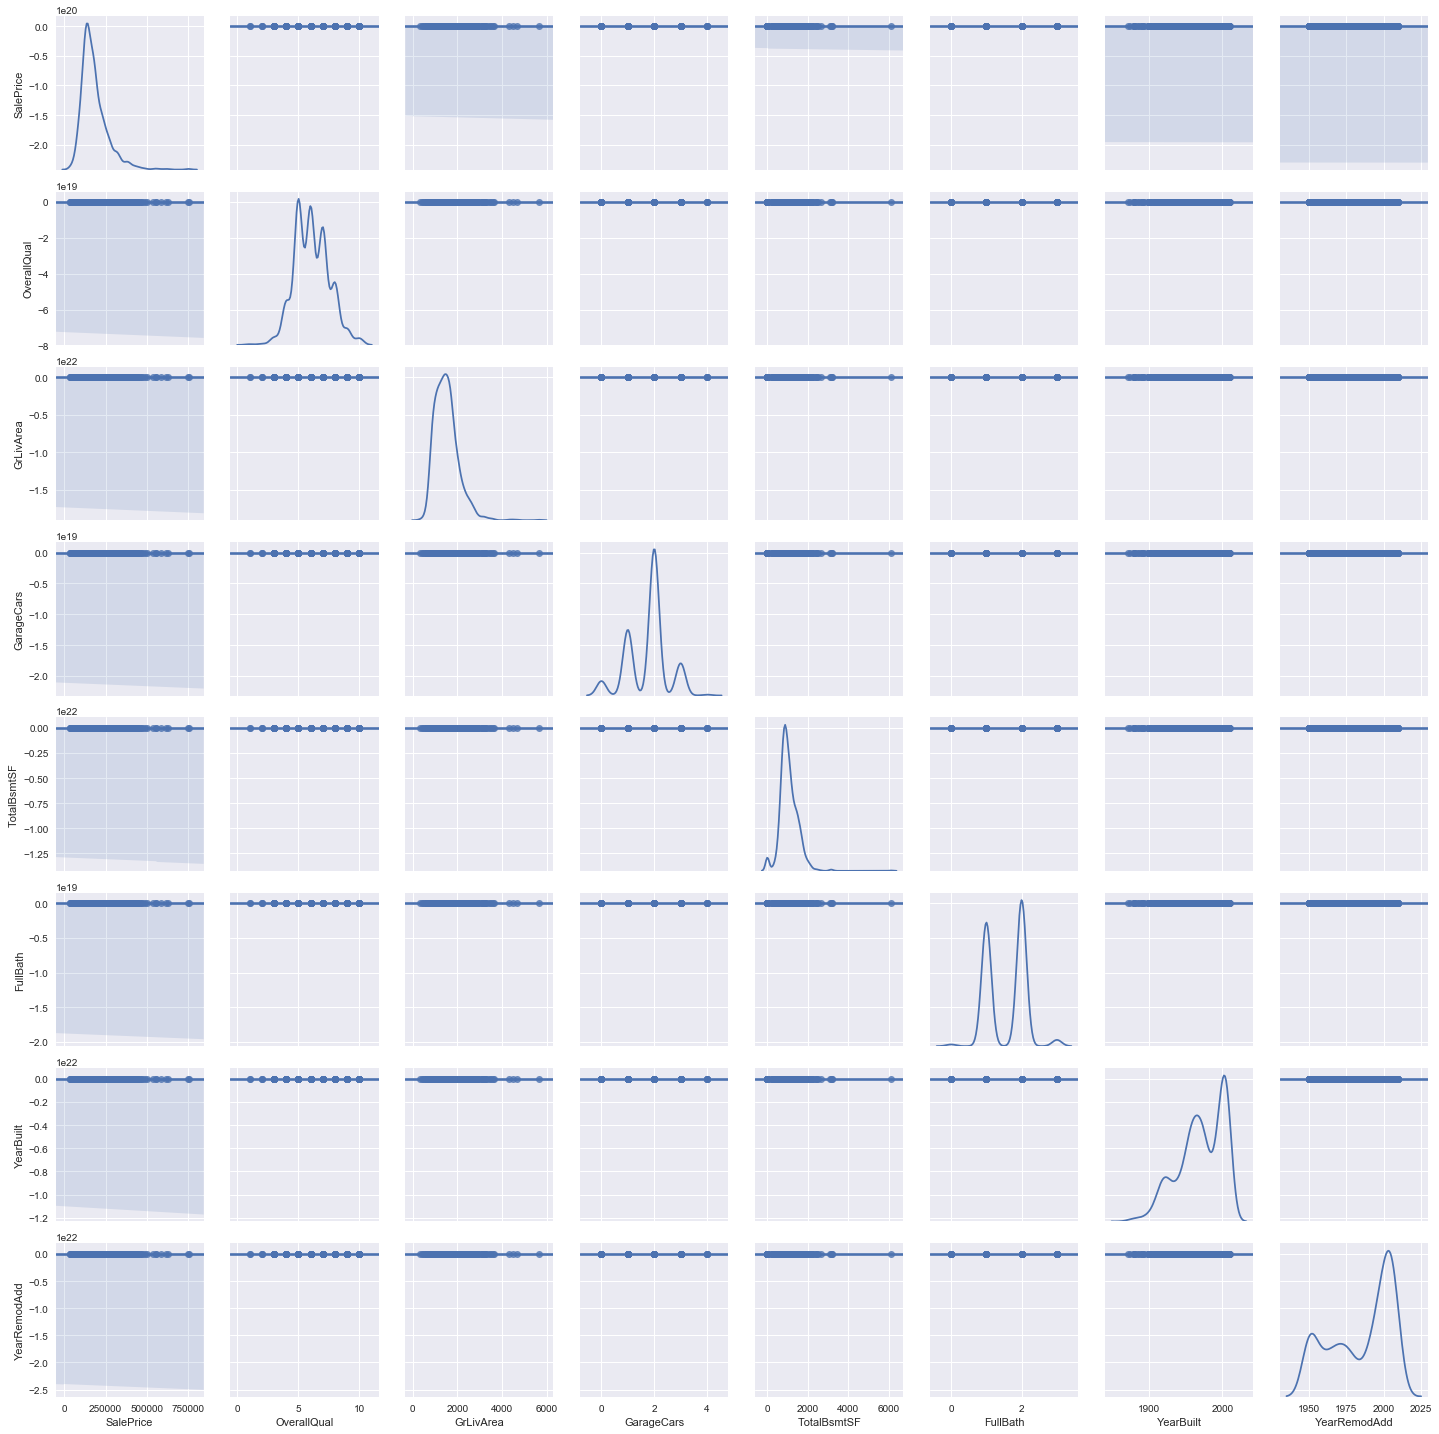

In [29]:
#scatterplots of top efeective varibles
sns.set()
colms = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt','YearRemodAdd']
#sns.pairplot(num_data[colms], size = 2.5, hue="OverallQual", palette="husl", kind="reg", diag_kind="kde")
sns.pairplot(num_data[colms], size = 2.5, palette="Set3", kind="reg", diag_kind="kde")
plt.show();

# Following plots indicate me that there is Skewness in Salesprice, GrLiveArea,TotalBsmtSF, YearBuilt.
# we can normalised using log transform on above columns

# Building a models

In [30]:
# importing library for differents models
from sklearn.linear_model import LinearRegression, Lasso,Ridge, LassoLarsIC, LassoCV, ElasticNet,BayesianRidge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.kernel_ridge import KernelRidge

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

In [31]:
# further split train and test data
# separating our train dataset into further train and test for cross valudation
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size = 0.1 , random_state = 0)
X_test.shape

(146, 347)

# function to calculate RMSE and Rsquare with 

In [32]:
# function to calculate root mean square error with crossvalidation
# input is the specifi model and output is the rmse and r^2 values

# calculate RMSE with cross validation
n_folds = 10
def rmse_cv(model,X_data,Y_data):
    kf=n_folds
    #kf = KFold(n_folds, shuffle=True, random_state=10).get_n_splits(X_data.values)
    rmse= np.sqrt(-cross_val_score(model, X_data.values, Y_data, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# function to calculate R^2 with cross validation
def rsquare_cv(model,X_data,Y_data):
    kf=n_folds
    rmse= np.sqrt(cross_val_score(model, X_data.values, Y_data, cv = kf))
    return(rmse)

# reducing the columns base on variance and f-test

In [ ]:
# removing columns with low variance
import sklearn.feature_selection as fs
x_new = fs.VarianceThreshold(threshold = 0.5).fit_transform(X1)
print(x_new.shape)

# model selection using f-test
import sklearn.feature_selection as fs
#### Your code here, call the result select2
select2 = fs.SelectKBest(fs.f_regression, k=30).fit_transform(X_train,y_train)
print(select2.shape)

(1458, 25)
(1312, 30)


## Ols regression

In [ ]:
#Ols model
ols = LinearRegression()
ols.fit(X_train,y_train)
y_pred_train=ols.predict(X_train)
y_pred=ols.predict(X_test)
print('ols R^2 for test data :', ols.score(X_test, y_test)) # R^2 for the ols model

# calculate these metrics by hand!
from sklearn import metrics
print('train-RMSE:', np.sqrt(metrics.mean_squared_error(y_train,y_pred_train)))
print('test-RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

score=rmse_cv(ols,X_test,y_test) # score with cross validation
rsquare=rsquare_cv(ols,X_test,y_test)
print('ols score -crossvalidation(rmse) : {:0.5f} ({:0.5f})'.format(score.mean(),score.std()))
print('ols-cross validation R^2 : {:0.5f} ({:0.5f})'.format(rsquare.mean(),rsquare.std()))



## Lasso regression

In [ ]:
# lasso regression ( more consise way)
# ElasNet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.5, random_state=1))

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score=rmse_cv(lasso,X_train,y_train) # score with cross validation
rsquare=rsquare_cv(lasso,X_train,y_train)
print('lasso score ( RMSE) : {:0.5f} ({:0.5f})'.format(score.mean(),score.std()))
print('lasso R^2 : {:0.5f} ({:0.5f})'.format(rsquare.mean(),rsquare.std()))


lasso.fit(X_train,y_train)
y_pred_train=lasso.predict(X_train)
y_pred=lasso.predict(X_test)
print('lasso R^2 for test data :', lasso.score(X_test, y_test)) # R^2 for the ols model

# calculate these metrics by hand!
from sklearn import metrics
print('train-RMSE:', np.sqrt(metrics.mean_squared_error(y_train,y_pred_train)))
print('test-RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))



In [ ]:
# Grid search on Lasso
# look how to choose fraction parameters range

from sklearn.model_selection import GridSearchCV
lasso = Lasso(random_state=1)

grid_param2 = [{'alpha': np.arange(0.0001, 0.001, 0.0001)}]

para_search2 = GridSearchCV(lasso, grid_param2, cv=5, return_train_score=True)
para_search2.fit(X_train,y_train)
para_search2.cv_results_
para_search2.grid_scores_

print(para_search2.best_score_)
print(para_search2.best_params_)

lasso_best = para_search2.best_estimator_
print(lasso_best.fit(X_train,y_train))
print(lasso_best.score(X_train,y_train))

In [ ]:
# validation curve -lasso
from sklearn.model_selection import validation_curve

# range to search parameters
param_range = np.arange(0.0001, 0.001, 0.0001)
# dictionary with parameters and range for gride
kwargs = dict(param_name='alpha', param_range=param_range)

#training and test scores for varying parameter values and k-fold cross validation
train_scores, test_scores = validation_curve(lasso, X_train,y_train, **kwargs, cv=5)
# take mean over all crossvalidate result(different sample)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
train_scores_mean

In [ ]:
# Train mean and standard deviation

plt.figure(figsize=(10,7))
plt.plot(param_range, train_scores_mean, color='r')
train_y1 = train_scores_mean - train_scores_std
train_y2 = train_scores_mean + train_scores_std
plt.fill_between(param_range, y1=train_y1, y2=train_y2, color='r', alpha=0.1)

# Test mean and standard deviation
plt.plot(param_range, test_scores_mean,color='b')
test_y1 = test_scores_mean - test_scores_std
test_y2 = test_scores_mean + test_scores_std
plt.xlabel('lambda',fontsize=15)
plt.ylabel('RSquare',fontsize=15)
plt.title('Grid Search for Lasso parameters', fontsize=20)
plt.legend(('Train', 'Validation'),loc='upper right')
plt.fill_between(param_range, y1=test_y1, y2=test_y2, color='b', alpha=0.1)
plt.savefig('Grid_lasso.png')
plt.show()

# on x axis , number of k
# to choose , two things need to consider, decrepancy and accruracy 

## Ridge regression

In [ ]:
#ridge regression
ridg=Ridge(alpha=9, random_state=1)
score=rmse_cv(ridg,X_train,y_train) # score with cross validation
rsquare=rsquare_cv(ridg,X_train,y_train)
print('Ridge score(RMSE) : {:0.5f} ({:0.5f})'.format(score.mean(),score.std()))
print('Ridge R^2 : {:0.5f} ({:0.5f})'.format(rsquare.mean(),rsquare.std()))


ridg.fit(X_train,y_train)
y_pred_train=ridg.predict(X_train)
y_pred=ridg.predict(X_test)
print('Ridge R^2 for test data :', ridg.score(X_test, y_test)) # R^2 for the ols model

# calculate these metrics by hand!
from sklearn import metrics
print('train-RMSE:', np.sqrt(metrics.mean_squared_error(y_train,y_pred_train)))
print('test-RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))




In [ ]:
#Function to compute rmse for different values of lambda
def rmse_data(model,xdata,ydata,n):
    ridg=model(alpha=n, random_state=1)
    score=rmse_cv(ridg,X_train,y_train)
    return score.mean()
    
    
#Function to compute rmse for different values of lambda
def rmse_data_std(model,xdata,ydata,n):
    ridg=model(alpha=n, random_state=1)
    score=rmse_cv(ridg,X_train,y_train)
    return score.std()
    

In [ ]:
# Grid search on Ridge
# look how to choose fraction parameters range

from sklearn.model_selection import GridSearchCV
ridge = Ridge(random_state=1)

grid_param2 = [{'alpha': np.arange(0,50,1)}]

para_search2 = GridSearchCV(ridge, grid_param2, cv=10, return_train_score=True)
para_search2.fit(X_train,y_train)
para_search2.cv_results_
para_search2.grid_scores_

print(para_search2.best_score_)
print(para_search2.best_params_)

ridge_best = para_search2.best_estimator_
print(ridge_best.fit(X_train,y_train))
print(ridge_best.score(X_train,y_train))

In [ ]:
# validation curve-lasso
from sklearn.model_selection import validation_curve

# range to search parameters
param_range = np.arange(1,50,2)
# dictionary with parameters and range for gride
kwargs = dict(param_name='alpha', param_range=param_range)

#training and test scores for varying parameter values and k-fold cross validation
train_scores, test_scores = validation_curve(ridge, X_train,y_train, **kwargs, cv=5)

# take mean over all crossvalidate result(different sample)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
print(test_scores_mean)

# Train mean and standard deviation

plt.figure(figsize=(10,7))
plt.plot(param_range, train_scores_mean, color='r')
train_y1 = train_scores_mean - train_scores_std
train_y2 = train_scores_mean + train_scores_std
plt.fill_between(param_range, y1=train_y1, y2=train_y2, color='r', alpha=0.1)

# Test mean and standard deviation
plt.plot(param_range, test_scores_mean,color='b')
test_y1 = test_scores_mean - test_scores_std
test_y2 = test_scores_mean + test_scores_std
plt.xlabel('lambda',fontsize=15)
plt.ylabel('RSquare',fontsize=15)
plt.title('Grid Search for Ridge parameters', fontsize=20)
plt.legend(('Train', 'Validation'),loc='upper right')
plt.fill_between(param_range, y1=test_y1, y2=test_y2, color='b', alpha=0.1)
plt.savefig('Grid_ridge.png')
plt.show()

# on x axis , number of k
# to choose , two things need to consider, decrepancy and accruracy 

## ElasticNet regression

In [ ]:
#elastic net regression
ENet=ElasticNet(alpha=0.0007,l1_ratio=0.5,random_state=1)
#ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score=rmse_cv(ENet,X_train,y_train) # score with cross validation
rsquare=rsquare_cv(ENet,X_train,y_train)
print('Elastic Net score (RMSE) : {:0.5f} ({:0.5f})'.format(score.mean(),score.std()))
print('Elastic Net R^2 : {:0.5f} ({:0.5f})'.format(rsquare.mean(),rsquare.std()))


ENet.fit(X_train,y_train)
y_pred_train=ENet.predict(X_train)
y_pred=ENet.predict(X_test)
print('ElasticNet R^2 for test data :', ENet.score(X_test, y_test)) # R^2 for the ols model

# calculate these metrics by hand!
from sklearn import metrics
print('train-RMSE:', np.sqrt(metrics.mean_squared_error(y_train,y_pred_train)))
print('test-RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))


In [ ]:
# Grid search on ElasticNet
# look how to choose fraction parameters range

from sklearn.model_selection import GridSearchCV
ENet = ElasticNet(random_state=1)

grid_param2 = [{'alpha': np.arange(0.0001,0.001,0.0001),'l1_ratio':np.arange(0,1,0.1)}]
grid_param2 = [{'alpha': np.arange(0.0001,0.001,0.0001)}]


para_search2 = GridSearchCV(ENet, grid_param2, cv=10, return_train_score=True)
para_search2.fit(X_train,y_train)
para_search2.cv_results_
para_search2.grid_scores_

print(para_search2.best_score_)
print(para_search2.best_params_)

ENet_best = para_search2.best_estimator_
print(ENet_best.fit(X_train,y_train))
print(ENet_best.score(X_train,y_train))

In [ ]:
# validation curve -ENet
from sklearn.model_selection import validation_curve

# range to search parameters
param_range = np.arange(0.0001, 0.002,0.0002)
# dictionary with parameters and range for gride
kwargs = dict(param_name='alpha', param_range=param_range)

#training and test scores for varying parameter values and k-fold cross validation
train_scores, test_scores = validation_curve(ENet, X_train,y_train, **kwargs, cv=5)
# take mean over all crossvalidate result(different sample)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
print(test_scores_mean)


# Train mean and standard deviation

plt.figure(figsize=(10,7))
plt.plot(param_range, train_scores_mean, color='r')
train_y1 = train_scores_mean - train_scores_std
train_y2 = train_scores_mean + train_scores_std
plt.fill_between(param_range, y1=train_y1, y2=train_y2, color='r', alpha=0.1)

# Test mean and standard deviation
plt.plot(param_range, test_scores_mean,color='b')
test_y1 = test_scores_mean - test_scores_std
test_y2 = test_scores_mean + test_scores_std
plt.xlabel('lambda',fontsize=15)
plt.ylabel('RSquare',fontsize=15)
plt.title('Grid Search for ElasticNet parameters', fontsize=20)
plt.legend(('Train', 'Validation'),loc='upper right')
plt.fill_between(param_range, y1=test_y1, y2=test_y2, color='b', alpha=0.1)
plt.savefig('Grid_Enet.png')
plt.show()

# on x axis , number of k
# to choose , two things need to consider, decrepancy and accruracy 

# Tree base models

## Random forest regression

In [2]:
Rand_For=RandomForestRegressor(n_estimators=20,max_depth=10,max_features=30)
score=rmse_cv(Rand_For,X_train,y_train) # score with cross validation
rsquare=rsquare_cv(Rand_For,X_train,y_train)
print('Random Forest score (RMSE) : {:0.5f} ({:0.5f})'.format(score.mean(),score.std()))
print('Random Forest R^2 : {:0.5f} ({:0.5f})'.format(rsquare.mean(),rsquare.std()))


Rand_For.fit(X_train,y_train)
y_pred_train=Rand_For.predict(X_train)
y_pred=Rand_For.predict(X_test)
print('Random Forest R^2 for test data :', Rand_For.score(X_test, y_test)) # R^2 for the ols model

# calculate these metrics by hand!
from sklearn import metrics
print('train-RMSE:', np.sqrt(metrics.mean_squared_error(y_train,y_pred_train)))
print('test-RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))



NameError: name 'RandomForestRegressor' is not defined

In [3]:
# grid search on Randomforest

from sklearn.model_selection import GridSearchCV
Rand_For=RandomForestRegressor()

grid_param2 = [{'n_estimators': np.arange(1,20,3),'max_depth':np.arange(1,20,3),'max_features':np.arange(1,50,10)}]

para_search2 = GridSearchCV(Rand_For, grid_param2, cv=10, return_train_score=True)
para_search2.fit(X_train,y_train)
#para_search2.cv_results_
#para_search2.grid_scores_

print(para_search2.best_score_)
print(para_search2.best_params_)

Rand_for_best = para_search2.best_estimator_
print(Rand_for_best.fit(X_train,y_train))
print(Rand_for_best.score(X_train,y_train))

NameError: name 'RandomForestRegressor' is not defined

[0.65966805 0.84193161 0.85023965 0.85717523 0.85573139 0.8626098
 0.86545528 0.86493726 0.86812022 0.86781759]


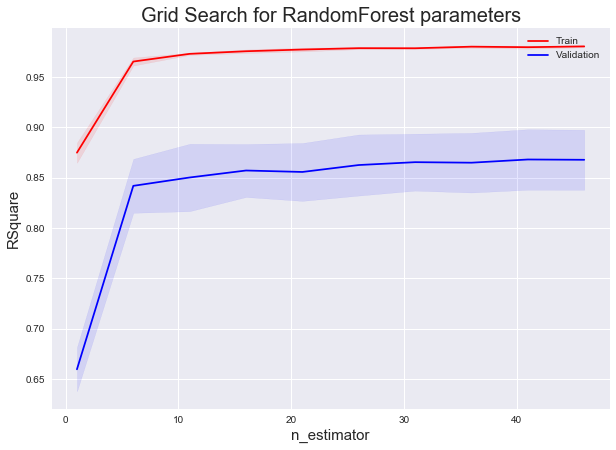

In [37]:
# validation curve -Random Forest
from sklearn.model_selection import validation_curve

# range to search parameters
param_range = np.arange(1,50,5)
# dictionary with parameters and range for gride
kwargs = dict(param_name='n_estimators', param_range=param_range)

#training and test scores for varying parameter values and k-fold cross validation
train_scores, test_scores = validation_curve(Rand_For, X_train,y_train, **kwargs, cv=5)
# take mean over all crossvalidate result(different sample)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
print(test_scores_mean)


# Train mean and standard deviation

plt.figure(figsize=(10,7))
plt.plot(param_range, train_scores_mean, color='r')
train_y1 = train_scores_mean - train_scores_std
train_y2 = train_scores_mean + train_scores_std
plt.fill_between(param_range, y1=train_y1, y2=train_y2, color='r', alpha=0.1)

# Test mean and standard deviation
plt.plot(param_range, test_scores_mean,color='b')
test_y1 = test_scores_mean - test_scores_std
test_y2 = test_scores_mean + test_scores_std
plt.xlabel('n_estimator',fontsize=15)
plt.ylabel('RSquare',fontsize=15)
plt.title('Grid Search for RandomForest parameters', fontsize=20)
plt.legend(('Train', 'Validation'),loc='upper right')
plt.fill_between(param_range, y1=test_y1, y2=test_y2, color='b', alpha=0.1)
plt.savefig('Rand_for_n_estimator.png')
plt.show()

# on x axis , number of k
# to choose , two things need to consider, decrepancy and accruracy 

## Bagging regression

In [38]:
from sklearn.linear_model import ElasticNetCV

elastic_net = ElasticNetCV(alphas=[.001], max_iter=3000).fit(X_train, y_train)
elastic_net


ElasticNetCV(alphas=[0.001], copy_X=True, cv=None, eps=0.001,
       fit_intercept=True, l1_ratio=0.5, max_iter=3000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [39]:

bag = BaggingRegressor(base_estimator=elastic_net, n_estimators=10)
score=rmse_cv(bag,X_train,y_train) # score with cross validation
rsquare=rsquare_cv(bag,X_train,y_train)
print('Bagging (RMSE) score : {:0.5f} ({:0.5f})'.format(score.mean(),score.std()))
print('Bagging R^2 : {:0.5f} ({:0.5f})'.format(rsquare.mean(),rsquare.std()))



bag.fit(X_train,y_train)
y_pred_train=bag.predict(X_train)
y_pred=bag.predict(X_test)
print('Bagging R^2 for test data :', bag.score(X_test, y_test)) # R^2 for the ols model

# calculate these metrics by hand!
from sklearn import metrics
print('train-RMSE:', np.sqrt(metrics.mean_squared_error(y_train,y_pred_train)))
print('test-RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))


Bagging (RMSE) score : 0.11520 (0.01665)
Bagging R^2 : 0.95452 (0.01287)
Bagging R^2 for test data : 0.9369355383960066
train-RMSE: 0.09964030112893764
test-RMSE: 0.10779426255971766


In [40]:
# Grid search Bagging
from sklearn.model_selection import GridSearchCV
bag = BaggingRegressor(base_estimator=elastic_net)

#grid_param2 = [{'n_estimators':np.arange(1,20,2), 'max_samples':np.arange(1,5,1),'max_features':np.arange(1,5,1)}]
grid_param2 = [{'n_estimators':np.arange(1,20,2)}]


para_search2 = GridSearchCV(bag, grid_param2, cv=5, return_train_score=True)

para_search2.fit(X_train,y_train)
#para_search2.cv_results_
#para_search2.grid_scores_

print(para_search2.best_score_)
print(para_search2.best_params_)

Rand_for_best = para_search2.best_estimator_
print(Rand_for_best.fit(X_train,y_train))
print(Rand_for_best.score(X_train,y_train))

0.9096810905976711
{'n_estimators': 11}
BaggingRegressor(base_estimator=ElasticNetCV(alphas=[0.001], copy_X=True, cv=None, eps=0.001,
       fit_intercept=True, l1_ratio=0.5, max_iter=3000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=11, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
0.9364844540632358


[0.89674278 0.90511188 0.90581    0.90741566 0.90950213 0.9083368
 0.91015693 0.90891895 0.90889514 0.90819173]


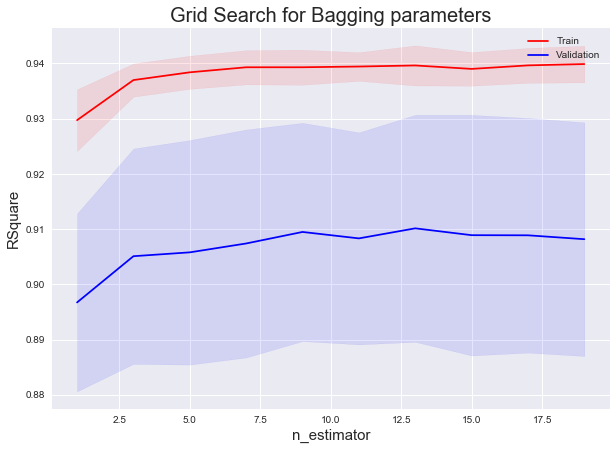

In [41]:
# validation curve -Bagging
from sklearn.model_selection import validation_curve

bag = BaggingRegressor(base_estimator=elastic_net)

# range to search parameters
param_range = np.arange(1,20,2)
# dictionary with parameters and range for gride
kwargs = dict(param_name='n_estimators', param_range=param_range)

#training and test scores for varying parameter values and k-fold cross validation
train_scores, test_scores = validation_curve(bag, X_train,y_train, **kwargs, cv=5)
# take mean over all crossvalidate result(different sample)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
print(test_scores_mean)


# Train mean and standard deviation

plt.figure(figsize=(10,7))
plt.plot(param_range, train_scores_mean, color='r')
train_y1 = train_scores_mean - train_scores_std
train_y2 = train_scores_mean + train_scores_std
plt.fill_between(param_range, y1=train_y1, y2=train_y2, color='r', alpha=0.1)

# Test mean and standard deviation
plt.plot(param_range, test_scores_mean,color='b')
test_y1 = test_scores_mean - test_scores_std
test_y2 = test_scores_mean + test_scores_std
plt.xlabel('n_estimator',fontsize=15)
plt.ylabel('RSquare',fontsize=15)
plt.title('Grid Search for Bagging parameters', fontsize=20)
plt.legend(('Train', 'Validation'),loc='upper right')
plt.fill_between(param_range, y1=test_y1, y2=test_y2, color='b', alpha=0.1)
plt.savefig('Bagging_n_estimator.png')
plt.show()

# on x axis , number of k
# to choose , two things need to consider, decrepancy and accruracy 

[0.0948668  0.67987107 0.81005719 0.84186487 0.87777631]


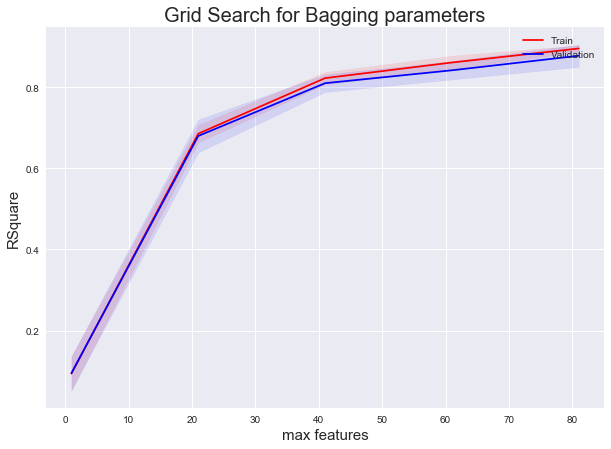

In [42]:
# validation curve -Bagging ( max-features)

from sklearn.model_selection import validation_curve
#bag = BaggingRegressor()


# range to search parameters
param_range = np.arange(1,100,20)
# dictionary with parameters and range for gride
kwargs = dict(param_name='max_features', param_range=param_range)

#training and test scores for varying parameter values and k-fold cross validation
train_scores, test_scores = validation_curve(bag, X_train,y_train, **kwargs, cv=5)
# take mean over all crossvalidate result(different sample)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
print(test_scores_mean)


# Train mean and standard deviation

plt.figure(figsize=(10,7))
plt.plot(param_range, train_scores_mean, color='r')
train_y1 = train_scores_mean - train_scores_std
train_y2 = train_scores_mean + train_scores_std
plt.fill_between(param_range, y1=train_y1, y2=train_y2, color='r', alpha=0.1)

# Test mean and standard deviation
plt.plot(param_range, test_scores_mean,color='b')
test_y1 = test_scores_mean - test_scores_std
test_y2 = test_scores_mean + test_scores_std
plt.xlabel('max features',fontsize=15)
plt.ylabel('RSquare',fontsize=15)
plt.title('Grid Search for Bagging parameters', fontsize=20)
plt.legend(('Train', 'Validation'),loc='upper right')
plt.fill_between(param_range, y1=test_y1, y2=test_y2, color='b', alpha=0.1)
plt.savefig('Bagging_max_features.png')
plt.show()

# on x axis , number of k
# to choose , two things need to consider, decrepancy and accruracy 

In [4]:
# validation curve -Bagging ( max-sample)

from sklearn.model_selection import validation_curve
bag = BaggingRegressor()

# range to search parameters
param_range = np.arange(1,300,30)
# dictionary with parameters and range for gride
kwargs = dict(param_name='max_samples', param_range=param_range)

#training and test scores for varying parameter values and k-fold cross validation
train_scores, test_scores = validation_curve(bag, X_train,y_train, **kwargs, cv=5)
# take mean over all crossvalidate result(different sample)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
print(test_scores_mean)


# Train mean and standard deviation

plt.figure(figsize=(10,7))
plt.plot(param_range, train_scores_mean, color='r')
train_y1 = train_scores_mean - train_scores_std
train_y2 = train_scores_mean + train_scores_std
plt.fill_between(param_range, y1=train_y1, y2=train_y2, color='r', alpha=0.1)

# Test mean and standard deviation
plt.plot(param_range, test_scores_mean,color='b')
test_y1 = test_scores_mean - test_scores_std
test_y2 = test_scores_mean + test_scores_std
plt.xlabel('max sample',fontsize=15)
plt.ylabel('RSquare',fontsize=15)
plt.title('Grid Search for Bagging parameters', fontsize=20)
plt.legend(('Train', 'Validation'),loc='upper right')
plt.fill_between(param_range, y1=test_y1, y2=test_y2, color='b', alpha=0.1)
plt.savefig('Bagging_max_sample.png')
plt.show()

# on x axis , number of k
# to choose , two things need to consider, decrepancy and accruracy 

NameError: name 'BaggingRegressor' is not defined

## Boosting regression

In [44]:
#gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.085,max_depth=2, max_features=10,loss="huber")

In [45]:
#gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.085,max_depth=2, max_features=10,loss="huber")
gboost = GradientBoostingRegressor()
score=rmse_cv(gboost,X_train,y_train) # score with cross validation
rsquare=rsquare_cv(gboost,X_train,y_train)
print('Gradient boost score (RMSE) : {:0.5f} ({:0.5f})'.format(score.mean(),score.std()))
print('Gradiaent boost R^2 : {:0.5f} ({:0.5f})'.format(rsquare.mean(),rsquare.std()))



gboost.fit(X_train,y_train)
y_pred_train=gboost.predict(X_train)
y_pred=gboost.predict(X_test)
print('Bagging R^2 for test data :', gboost.score(X_test, y_test)) # R^2 for the ols model

# calculate these metrics by hand!
from sklearn import metrics
print('train-RMSE:', np.sqrt(metrics.mean_squared_error(y_train,y_pred_train)))
print('test-RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))



Gradient boost score (RMSE) : 0.12884 (0.01650)
Gradiaent boost R^2 : 0.94370 (0.01435)
Bagging R^2 for test data : 0.9091288454968746
train-RMSE: 0.08228369588406617
test-RMSE: 0.1293946506659553


In [46]:
# grid search for boosting parameters

from sklearn.model_selection import GridSearchCV

grid_param2 = [{'n_estimators':np.arange(200,1500,300),'learning_rate':np.arange(0.01,0.1,0.02), 'max_depth':np.arange(1,5,2), 'max_features':np.arange(1,15,3)}]

para_search2 = GridSearchCV(gboost, grid_param2, cv=5, return_train_score=True)

para_search2.fit(X_train,y_train)
#para_search2.cv_results_
#para_search2.grid_scores_

print(para_search2.best_score_)
print(para_search2.best_params_)

Rand_for_best = para_search2.best_estimator_
print(Rand_for_best.fit(X_train,y_train))
print(Rand_for_best.score(X_train,y_train))

KeyboardInterrupt: 

In [ ]:
# validation curve -Bagging
from sklearn.model_selection import validation_curve

# range to search parameters
param_range = np.arange(1,20,2)
# dictionary with parameters and range for gride
kwargs = dict(param_name='n_estimators', param_range=param_range)

#training and test scores for varying parameter values and k-fold cross validation
train_scores, test_scores = validation_curve(gboost, X_train,y_train, **kwargs, cv=5)
# take mean over all crossvalidate result(different sample)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
print(test_scores_mean)


# Train mean and standard deviation

plt.figure(figsize=(10,7))
plt.plot(param_range, train_scores_mean, color='r')
train_y1 = train_scores_mean - train_scores_std
train_y2 = train_scores_mean + train_scores_std
plt.fill_between(param_range, y1=train_y1, y2=train_y2, color='r', alpha=0.1)

# Test mean and standard deviation
plt.plot(param_range, test_scores_mean,color='b')
test_y1 = test_scores_mean - test_scores_std
test_y2 = test_scores_mean + test_scores_std
plt.xlabel('n_estimator',fontsize=15)
plt.ylabel('RSquare',fontsize=15)
plt.title('Grid Search for gboosting parameters', fontsize=20)
plt.legend(('Train', 'Validation'),loc='upper right')
plt.fill_between(param_range, y1=test_y1, y2=test_y2, color='b', alpha=0.1)
plt.savefig('gboosting_n_estimator.png')
plt.show()

# on x axis , number of k
# to choose , two things need to consider, decrepancy and accruracy 

## XGboost regression

In [47]:
import xgboost as xgb
xgboo = xgb.XGBRegressor()
score=rmse_cv(xgboo,X_train,y_train) # score with cross validation
rsquare=rsquare_cv(xgboo,X_train,y_train)
print('XGboost score (RMSE) : {:0.5f} ({:0.5f})'.format(score.mean(),score.std()))
print('XGboost R^2 : {:0.5f} ({:0.5f})'.format(rsquare.mean(),rsquare.std()))


xgboo.fit(X_train,y_train)
y_pred_train=xgboo.predict(X_train)
y_pred=xgboo.predict(X_test)
print('XGboost R^2 for test data :', xgboo.score(X_test, y_test)) # R^2 for the ols model

# calculate these metrics by hand!
from sklearn import metrics
print('train-RMSE:', np.sqrt(metrics.mean_squared_error(y_train,y_pred_train)))
print('test-RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))



XGboost score (RMSE) : 0.13129 (0.01859)
XGboost R^2 : 0.94153 (0.01561)
XGboost R^2 for test data : 0.9195019932366425
train-RMSE: 0.08688328356554406
test-RMSE: 0.12178557837096693


In [ ]:
xgboo = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

score=rmse_cv(xgboo,X_train,y_train) # score with cross validation
rsquare=rsquare_cv(xgboo,X_train,y_train)
print('XGboost score : {:0.5f} ({:0.5f})'.format(score.mean(),score.std()))
print('XGboost R^2 : {:0.5f} ({:0.5f})'.format(rsquare.mean(),rsquare.std()))


# final Prediction on test data set with Lasso and ElasticNet

In [48]:
# lasso regression ( more consise way)
# ElasNet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.5, random_state=1))

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso.fit(X_train,y_train)
np.exp(lasso.predict(X2))

array([111142.52372625, 177150.4426667 , 192727.07511309, ...,
       139765.12792119, 125809.63034523, 212521.83515733])

In [49]:
# Ridge regression
ridg=Ridge(alpha=9, random_state=1)
ridg.fit(X_train,y_train)
np.exp(ridg.predict(X2))

array([ 96253.46323171, 159119.96763944, 167801.12338172, ...,
       126703.09528808, 115862.78456283, 208782.09394006])

In [1]:
# ElasticNEt regression

#elastic net regression
ENet=ElasticNet(alpha=0.0007,l1_ratio=0.5,random_state=1)
ENet.fit(X_train,y_train)
np.exp(ENet.predict(X2))

NameError: name 'ElasticNet' is not defined

In [54]:
import xgboost as xgb
xgboo = xgb.XGBRegressor()
xgboo.fit(X_train,y_train)
np.exp(xgboo.predict(X2))

ValueError: feature_names mismatch: ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'Alley_None', 'Alley_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'OverallQual_1', 'OverallQual_10', 'OverallQual_2', 'OverallQual_3', 'OverallQual_4', 'OverallQual_5', 'OverallQual_6', 'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'OverallCond_1', 'OverallCond_2', 'OverallCond_3', 'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'OverallCond_7', 'OverallCond_8', 'OverallCond_9', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_None', 'BsmtQual_TA', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_None', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtExposure_None', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_None', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_None', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf', 'Heating_Floor', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'Functional_Maj1', 'Functional_Maj2', 'Functional_Min1', 'Functional_Min2', 'Functional_Mod', 'Functional_Sev', 'Functional_Typ', 'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_None', 'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageType_None', 'GarageFinish_Fin', 'GarageFinish_None', 'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageQual_Ex', 'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_None', 'GarageQual_Po', 'GarageQual_TA', 'GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_None', 'GarageCond_Po', 'GarageCond_TA', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'PoolQC_Ex', 'PoolQC_Fa', 'PoolQC_Gd', 'PoolQC_None', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'Fence_None', 'MiscFeature_Gar2', 'MiscFeature_None', 'MiscFeature_Othr', 'MiscFeature_Shed', 'MiscFeature_TenC', 'MoSold_1', 'MoSold_10', 'MoSold_11', 'MoSold_12', 'MoSold_2', 'MoSold_3', 'MoSold_4', 'MoSold_5', 'MoSold_6', 'MoSold_7', 'MoSold_8', 'MoSold_9', 'YrSold_2006', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial'] ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'Alley_None', 'Alley_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'OverallQual_1', 'OverallQual_10', 'OverallQual_2', 'OverallQual_3', 'OverallQual_4', 'OverallQual_5', 'OverallQual_6', 'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'OverallCond_1', 'OverallCond_2', 'OverallCond_3', 'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'OverallCond_7', 'OverallCond_8', 'OverallCond_9', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_CompShg', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_None', 'BsmtQual_TA', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_None', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtExposure_None', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_None', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_None', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_Wall', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_SBrkr', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'Functional_Maj1', 'Functional_Maj2', 'Functional_Min1', 'Functional_Min2', 'Functional_Mod', 'Functional_Sev', 'Functional_Typ', 'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_None', 'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageType_None', 'GarageFinish_Fin', 'GarageFinish_None', 'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_None', 'GarageQual_Po', 'GarageQual_TA', 'GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_None', 'GarageCond_Po', 'GarageCond_TA', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'PoolQC_Ex', 'PoolQC_Gd', 'PoolQC_None', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'Fence_None', 'MiscFeature_Gar2', 'MiscFeature_None', 'MiscFeature_Othr', 'MiscFeature_Shed', 'MoSold_1', 'MoSold_10', 'MoSold_11', 'MoSold_12', 'MoSold_2', 'MoSold_3', 'MoSold_4', 'MoSold_5', 'MoSold_6', 'MoSold_7', 'MoSold_8', 'MoSold_9', 'YrSold_2006', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial', 'Utilities_NoSeWa', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_2.5Fin', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_Other', 'Heating_Floor', 'Heating_OthW', 'Electrical_Mix', 'GarageQual_Ex', 'PoolQC_Fa', 'MiscFeature_TenC']

In [ ]:
# stacking predictions , may be do more sofisticated
combined_pred = (
    lm.predict(test) +
    model_xgb.predict(test) +
    bag.predict(test) +
    model_lasso.predict(test) +
    elastic_net.predict(test) +
    gboost.predict(test)) / 6
# print('R2: {}'.format(r2_score(combined_pred, y_test)))

# stacking or ensamble of the models

# Multilinear regression Model building starting

In [77]:
# dividing feature and target variables from numerical data only
X = num_data.iloc[:, :-1] # features
y = num_data.iloc[:, -1] # targets
X.head(5)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,548,0,61,0,0,0,0,0,2,2008
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,460,298,0,0,0,0,0,0,5,2007
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,608,0,42,0,0,0,0,0,9,2008
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,642,0,35,272,0,0,0,0,2,2006
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,836,192,84,0,0,0,0,0,12,2008


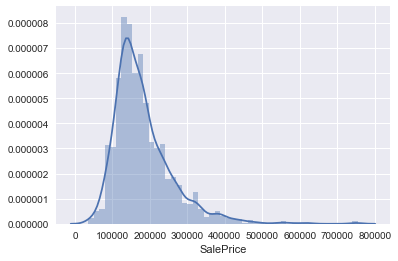

In [78]:
# looking target variables ( sales price)
X1=X
y.describe()
sns.distplot(y)

# building simple regression model

In [79]:
# Splitting the dataset into the Training set and Test set

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.2 , random_state = 1)

# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)


In [86]:
from math import sqrt

# measure R^2, RSS score
regressor.score(X_train,y_train)
print('R^2', regressor.score(X_test,y_test))
print("RSS: %.2f" % np.sum((y_test - regressor.predict(X_test))**2))
print(sum(abs(y_test - regressor.predict(X_test)))/292)
print(sqrt(np.sum(y_test - regressor.predict(X_test))**2)/292)



R^2 0.8190193003573013
RSS: 376897277811.91
21551.356793330942
3388.2146556364946


In [87]:
#### multiple linear regression fit with ols

from sklearn import linear_model
ols = linear_model.LinearRegression()

ols.fit(X_train,y_train)

print("R^2: %.5f" % ols.score(X_train, y_train))
print("RSS: %.2f" % np.sum((ols.predict(X_train) - y_train) ** 2))
print(sqrt(np.sum((ols.predict(X_train) - y_train) ** 2))/292)


R^2: 0.80872
RSS: 1361087350999.96
3995.3989168405765


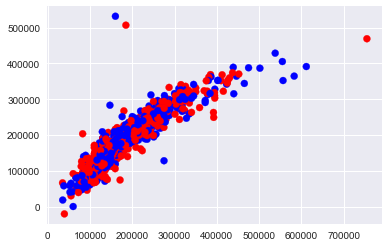

In [88]:
# visualization of prediction
plt.scatter(y_train,ols.predict(X_train), c=['r','b'])

In [99]:
# calculate these metrics by hand!
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(np.log(y_test),np.log(y_pred)))
print('MSE:', metrics.mean_squared_error(np.log(y_test),np.log(y_pred)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(np.log(y_test),np.log(y_pred))))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

MAE: 0.13890274495241342
MSE: 0.05105833502829446
RMSE: 0.22596091482443253
RMSE: 35926.92725652428


# SVR regression